## Convolutional Neural Networks


The code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  



### The Road Ahead

We break the project in following parts.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    print data
    return dog_files, dog_targets
# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [14]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.


('Number of faces detected:', 1)


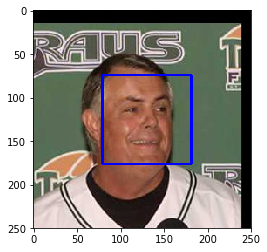

In [15]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [16]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


In [17]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
h_count = [hum for hum in human_files_short if face_detector(hum)]
d_count = [dog for dog in dog_files_short if face_detector(dog)]
print 'Percentage of faces detected in human dataset: {}%'.format(len(h_count))
print 'Percentage of faces detected in dog dataset: {}%'.format(len(d_count))
        

Percentage of faces detected in human dataset: 100%
Percentage of faces detected in dog dataset: 12%


__This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face.__ 

We think it's reasonable demand from a developer's point of view but is hard to put these restrictions on the user. One way to detect face image that are unclear might be to train CNN over the differnt orientation of faces in different images and images can be augmented to train CNNs to detect face image in an unclear image.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [18]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [19]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [20]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [21]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))


### Assessing the Dog Detector


In [22]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_dog = [d for d in dog_files_short if dog_detector(d)]
human_dog = [h for h in human_files_short if dog_detector(h)]
print '{:.2f}% of images in human_files_Short have detected a dog'.format((len(human_dog)/len(human_files_short))*100)
print '{:.2f}% of images in dog_files_Short have detected a dog'.format((len(dog_dog)/len(dog_files_short))*100)
                                                                          

0.00% of images in human_files_Short have detected a dog
100.00% of images in dog_files_Short have detected a dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.
 
### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [23]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 121.34it/s]


### Model Architecture

Design a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We designed the initial architecture of CNN with 3 convolutional layers and 3 maxpooling layers in between to reduce dimensionality and using GlobalAveragePooling2D and using Dense(fully conected layer) at the end with same nodes as the number of possible outputs there can be given the dataset.

In [24]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=(5,5), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(3,3), padding='valid'))
model.add(Conv2D(filters = 32, kernel_size=(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Conv2D(filters = 64, kernel_size = (5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_names)))
model.add(Activation('softmax'))

          
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
activation_99 (Activation)   (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
activation_100 (Activation)  (None, 69, 69, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        51264     
__________

### Compile the Model

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [26]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6660/6680 [============================>.] - ETA: 1s - loss: 4.8754 - acc: 0.0108
Epoch 00001: val_loss improved from inf to 4.81360, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 448s 67ms/step - loss: 4.8753 - acc: 0.0108 - val_loss: 4.8136 - val_acc: 0.0180
Epoch 2/5
6660/6680 [============================>.] - ETA: 1s - loss: 4.7870 - acc: 0.0180
Epoch 00002: val_loss improved from 4.81360 to 4.73198, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 474s 71ms/step - loss: 4.7870 - acc: 0.0183 - val_loss: 4.7320 - val_acc: 0.0228
Epoch 3/5
6660/6680 [============================>.] - ETA: 1s - loss: 4.7034 - acc: 0.0245
Epoch 00003: val_loss improved from 4.73198 to 4.67201, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 457s 68ms/step - loss: 4.7028 - acc:

### Load the Model with the Best Validation Loss

In [27]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.

In [28]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.0000%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.

### Obtain Bottleneck Features

In [29]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [31]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [32]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6540/6680 [============================>.] - ETA: 0s - loss: 12.1619 - acc: 0.1272
Epoch 00001: val_loss improved from inf to 10.27701, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 3s 482us/step - loss: 12.1122 - acc: 0.1296 - val_loss: 10.2770 - val_acc: 0.2347
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 9.3428 - acc: 0.3060
Epoch 00002: val_loss improved from 10.27701 to 9.23964, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 303us/step - loss: 9.3197 - acc: 0.3069 - val_loss: 9.2396 - val_acc: 0.3174
Epoch 3/20
6560/6680 [============================>.] - ETA: 0s - loss: 8.5161 - acc: 0.3883
Epoch 00003: val_loss improved from 9.23964 to 8.79434, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 285us/step - loss: 8.5040 - acc: 0.3895 - val_lo

### Load the Model with the Best Validation Loss

In [33]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [34]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.0000%


### Predict Dog Breed with the Model

In [35]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images. 

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [38]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

We added `GlobalAveragePooling2D` layer with input shape for the dimensionality reduction and finally added `Dense` layer as it is a fully connected layer with `softmax` as it's activation function since we need to classify the breeds of the dogs and softmax does a pretty good job in doing classification.

In [ ]:
resnet_model = Sequential()
resnet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
resnet_model.add(Dense(133))
resnet_model.add(Activation('softmax'))
resnet_model.summary()

In [ ]:
### Compile the model.
resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  . 

In [46]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.rmsprop.ResNet50.hdf5', verbose=1, save_best_only=True)
resnet_model.fit(train_ResNet50, train_targets, validation_data=(valid_ResNet50, valid_targets), epochs=40, batch_size=30 , callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6600/6680 [============================>.] - ETA: 0s - loss: 1.7592 - acc: 0.5764
Epoch 00001: val_loss improved from inf to 0.85894, saving model to saved_models/weights.best.rmsprop.ResNet50.hdf5
6680/6680 [==============================] - 3s 453us/step - loss: 1.7487 - acc: 0.5786 - val_loss: 0.8589 - val_acc: 0.7437
Epoch 2/40
6450/6680 [===========================>..] - ETA: 0s - loss: 0.4589 - acc: 0.8588
Epoch 00002: val_loss improved from 0.85894 to 0.74249, saving model to saved_models/weights.best.rmsprop.ResNet50.hdf5
6680/6680 [==============================] - 2s 243us/step - loss: 0.4553 - acc: 0.8602 - val_loss: 0.7425 - val_acc: 0.7725
Epoch 3/40
6570/6680 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9134
Epoch 00003: val_loss improved from 0.74249 to 0.71219, saving model to saved_models/weights.best.rmsprop.ResNet50.hdf5
6680/6680 [==============================] - 2s 234us/step - loss: 0

Epoch 31/40
6480/6680 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9988
Epoch 00031: val_loss did not improve
6680/6680 [==============================] - 1s 200us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.9867 - val_acc: 0.8311
Epoch 32/40
6570/6680 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9991
Epoch 00032: val_loss did not improve
6680/6680 [==============================] - 1s 210us/step - loss: 0.0038 - acc: 0.9990 - val_loss: 1.0377 - val_acc: 0.8216
Epoch 33/40
6600/6680 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9989
Epoch 00033: val_loss did not improve
6680/6680 [==============================] - 2s 252us/step - loss: 0.0038 - acc: 0.9990 - val_loss: 1.0142 - val_acc: 0.8299
Epoch 34/40
6540/6680 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9982
Epoch 00034: val_loss did not improve
6680/6680 [==============================] - 2s 346us/step - loss: 0.0046 - acc: 0.9982 - val_los

In [ ]:
### Load the model weights with the best validation loss.
resnet_model.load_weights('saved_models/weights.best.rmsprop.ResNet50.hdf5')

###  Test the Model

In [49]:
### Calculate classification accuracy on the test dataset.
resnet50_predicitions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]
test_accuracy = 100 * np.sum(np.array(resnet50_predicitions) == np.argmax(test_targets, axis=1)) / len(resnet50_predicitions)
print 'Test Accuracy:{:.4f}%'.format(test_accuracy)

Test Accuracy:81.0000%


###  Predict Dog Breed with the Model


In [ ]:
### This function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def predictBreed_resnet50(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
    
    
    

---
<a id='step6'></a>
## Step 6: Algorithm


In [ ]:

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def predict_breed(img_path):
    isHuman = face_detector(img_path)
    isDog = dog_detector(img_path)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if isHuman:
        print 'The image is likely to be a human image'
        print 'The person resembles "{}" breed of the dog'.format(predictBreed_resnet50(img_path))
    elif isDog:
        print 'The image is of a dog'
        print "The dog's breed is: {}".format(predictBreed_resnet50(img_path))
    else:
        print 'Image is neither a dog image nor of a human'

---
<a id='step7'></a>
## Step 7: Test Your Algorithm


In [ ]:

predict_breed('system_images/1.jpg')

Image is neither a dog image nor of a human


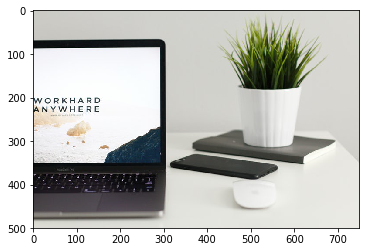

In [69]:
predict_breed('system_images/2.jpg')

Image is neither a dog image nor of a human


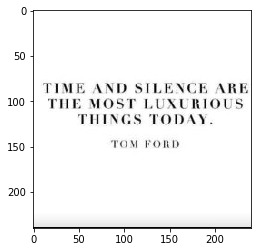

In [70]:
predict_breed('system_images/3.jpg')

The image is of a dog
The dog's breed is: Maltese


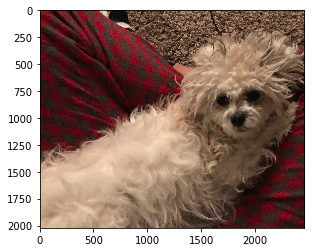

In [75]:
predict_breed('system_images/4.jpg')

The image is of a dog
The dog's breed is: Labrador_retriever


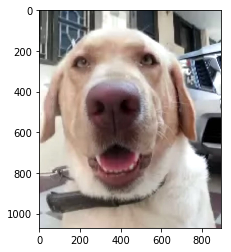

In [72]:
predict_breed('system_images/5.jpg')

The image is likely to be a human image
The person resembles "Silky_terrier" breed of the dog


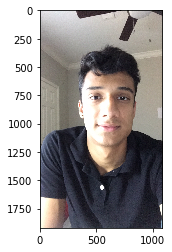

In [73]:
predict_breed('system_images/6.jpg')

The image is likely to be a human image
The person resembles "Silky_terrier" breed of the dog


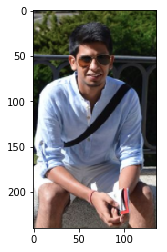

In [80]:
predict_breed('system_images/7.jpg')

The image is likely to be a human image
The person resembles "English_springer_spaniel" breed of the dog


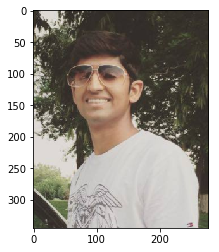

In [77]:
predict_breed('system_images/8.jpg')

The image is likely to be a human image
The person resembles "Black_russian_terrier" breed of the dog


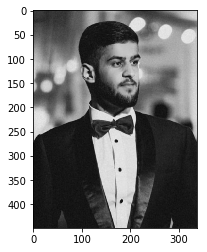

In [78]:
predict_breed('system_images/9.jpg')

The image is likely to be a human image
The person resembles "English_toy_spaniel" breed of the dog


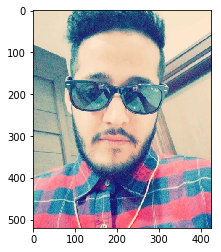

In [79]:
predict_breed('system_images/10.jpg')